In [1]:
#Importing the libraries
from matplotlib import pyplot as plt
import numpy as np 
from random import random
import math
import random as rand


In [2]:
#Defining the functions I used

# 1. Plotting function
def plotting(matrix, network=None, title="Plot"):

    fig,ax1 = plt.subplots()
    ax1.set_title(title)
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2")

    if network:
        x_min=-1.5
        x_max=1.5
        y_res=0.01
        x_res=0.01

        ys=np.arange(x_min,x_max,y_res)
        xs=np.arange(x_min,x_max,x_res)

        zs=[]

        for rand_y in np.arange(x_min,x_max,y_res):
            for rand_x in np.arange(x_min,x_max,x_res):
                zs.append(predict(network,[rand_x,rand_y,1]))

        xs,ys = np.meshgrid(xs,ys)
        zs = np.array(zs)
        zs = zs.reshape(xs.shape)

        plt.contourf(xs,ys,zs,levels=[-1,0,1],colors=('b','r'),alpha=0.3)

    class1_data=[[],[]]
    class0_data=[[],[]]

    for i in range(len(matrix)):
        i1_rand = matrix[i][0]
        i2_rand = matrix[i][1]
        y_rand  = matrix[i][-1]

        if y_rand==1:
            class1_data[0].append(i1_rand)
            class1_data[1].append(i2_rand)
        else:
            class0_data[0].append(i1_rand)
            class0_data[1].append(i2_rand)

    plt.xticks(np.arange(-1.5,1.5,0.5))
    plt.yticks(np.arange(-1.5,1.5,0.5))
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)

    plt.scatter(class0_data[0],class0_data[1],s=40.0,c='r',label='Class 0')
    plt.scatter(class1_data[0],class1_data[1],s=40.0,c='b',label='Class 1')

    plt.legend(fontsize=10,loc=1)
    plt.show()
    return

# 2. This function is to create a random (random weights) network of any configuration.
def create_network(n_inputs, layers_hidden, hidden_neurons: list, n_output):
    # The list input for hidden neurons is in case there is more than one hidden layers.

    network= list()
    for i in range(layers_hidden):
        layer =[]
        for j in range(hidden_neurons[i]):
            layer.append({"weights":[random() for j in range(n_inputs+1)]})
        network.append(layer)
    
    layer =[]

    for j in range(n_output):
        layer.append({"weights":[random() for j in range(hidden_neurons[-1]+1)]})
    network.append(layer)
    return network

# 3. This function is to run the actual training.
def training(network, matrix, epochs, learning_rate, n_output, error_plot = False, node_number_in_hidden_layer = 4):
    # The network should be a list of weights of different layers with appropriate number of layers and neurons in the layers.
    # Example a network with 2 input nodes (with 1 bias), 1 hidden layer with 2 nodes (with 1 bias) and one 1 node will look like:
    # [[{'weights': [0.16696199275834855, 0.9074274294852825, 0.7977612543253025]}, {'weights': [0.8403945031023915, 0.3699665961711708, 0.41002603124474046]}], [{'weights': [0.06221525252990556, 0.8261995420912167, 0.017695313965993886]}]]

    if(error_plot):
        f1 = plt.figure(1)
        ax1 = f1.add_subplot(111)
    error_plot_values = []
    for epoch in range(epochs):
        sum_error = 0
        for data_row in matrix:
            final_output = forward_propagate(network, data_row, activation_func = "Sigmoid")
            true_value = []
            for i in range(n_output):
                true_value.append(0)
            true_value[data_row[-1]] = 1
            for i in range(len(true_value)):
                sum_error += sum([(true_value[i]-final_output[i])**2 ])
            backprop(network,true_value)
            update_paramters(network, data_row, learning_rate)
        error_plot_values.append(sum_error)
        
        print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, learning_rate, sum_error))
        
    if(error_plot):
        Title_str = "Training Error with " +  str(node_number_in_hidden_layer) + " nodes"
        learning_rate_str = "Learning rate: " + str(learning_rate)
        epoch_plot_values = [i for i in range(1,epochs+1)]
        ax1.plot(epoch_plot_values,error_plot_values, '-b', label = 'Error')
        ax1.set_title(Title_str)
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Error")
        plt.figtext(0.77,0.7, learning_rate_str, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
        plt.legend()
        plt.show()
    return network

# 4. This function is for forward propagation for the complete network.
def forward_propagate(network,data,activation_func = "Sigmoid"):
    # This function handles the complete forward propagation of network for one set of data points.
    data = data[:-1]
    for layer in network:
        layer_output = []
        for node in layer:
            node_output = single_forward_pass(node['weights'],data,activation_func)
            node['Output'] = node_output
            layer_output.append(node_output)
        data = layer_output
    return data

# 5. This function if to calculate net sum for one node.
def single_forward_pass(node,data,activation_func):
    
    # This function is to calculate final output of a single neuron
    weighted_sum = node[-1]
    for w,x in zip(node[:-1],data):
        weighted_sum += w*x
    if(activation_func == "Sigmoid"):
        layer_output = sigmoid_activation_function(weighted_sum)
    elif(activation_func == "Signum"):
        layer_output = signum_activation_function(weighted_sum)
    return layer_output

# 6. This is the functio for the backpropagation step. It's called in the training function in every epoch.
def backprop(network, true_value):
    depth = len(network)
    for i in reversed(range(depth)):
        layer = network[i]
        layer_len = len(layer)
        update_term = []
        if i<depth-1:
            # Delta for the hidden layers
            for j in range(layer_len):
                error = 0
                for next_layer_node in network[i+1]:
                    error += next_layer_node['update_term'] * next_layer_node['weights'][j]
                update_term.append(error * derivative_for_sigmoid(layer[j]['Output']))
        else:
            # Delta for the last layer
            for j in range(layer_len):
                error = true_value[j] - layer[j]['Output']
                update_term.append(error * derivative_for_sigmoid(layer[j]['Output']))
        for k in range(layer_len):
            layer[k]['update_term'] = update_term[k]

# 7. This is the function to update the weights and biases after every backpropagation step.
def update_paramters(network, input_data, learning_rate):
    for idx,layer in enumerate(network):
        input_to_the_layer = input_data
        if idx!=0:
            input_to_the_layer = [node["Output"] for node in network[idx-1]]
        for node in layer:
            for j in range(len(input_to_the_layer)):
                node['weights'][j] += learning_rate * node['update_term'] * input_to_the_layer[j]
            # For the bias term
            node['weights'][-1] += learning_rate * node['update_term']
    return network

# 8. The function below is to determine the derivative output for a sigmoid unit.
def derivative_for_sigmoid(layer_output):
    return layer_output * (1.0 - layer_output)

# 9. The function below is for signum units.
def signum_activation_function(weighted_sum):
    if weighted_sum>=0:
        return 1
    elif weighted_sum<0:
        return -1  
    
# 10. The function below is for sigmoid units.
def sigmoid_activation_function(weighted_sum):
    return 1.0 / (1.0 + math.exp(-weighted_sum))

# 11. The function below is called everytime we have to make a prediction using a pretrained network.
def predict(network, input_data,activation_func = "Sigmoid"):
    output_val = forward_propagate(network, input_data)
    return output_val.index(max(output_val))

In [3]:
# In this cell I have defined all the datasets I've used in my code.

# This is the dataset provided in the homework.
data_provided_in_hw = [   [1, 0, 1],
            [0, 1, 1],
            [-1, 0, 1],
            [0, -1, 1],
            [0.5, 0.5, 0],
            [-0.5, 0.5, 0],
            [0.5, -0.5, 0],
            [-0.5, -0.5, 0] ]

# This is the dataset in which I combined some randomly generated points. All are in square of size 2 centered at origin.
training_dataset_expanded = [[1, 0, 1], [0, 1, 1], [-1, 0, 1], [0, -1, 1], [0.5, 0.5, 0], [-0.5, 0.5, 0], [0.5, -0.5, 0], [-0.5, -0.5, 0], [-0.1428184010985627, 0.256543871352656, 0], [-0.6055017606520186, -0.8519382697792959, 0], [0.14374747236290797, 0.699895385487844, 0], [0.14257440256747245, -0.10198940568098158, 0], [-0.24949273504131675, -0.772642103020166, 0], [-0.2013281428676914, -0.3742237472727483, 0], [-0.9966179304043437, -0.3518974136720767, 0], [0.5796020193772857, 0.6697503119403709, 0], [-0.3328619498891059, 0.09760996901061691, 0], [0.9794487794728348, 0.06137776895517244, 0], [-0.9961572506307057, -0.6253251599538081, 0], [0.06201932651114128, -0.9873180566561062, 0], [-0.33673139165081345, 0.5347644768966693, 0], [-0.9920920446326305, 0.38959271463394685, 0], [-0.8967331844370654, 0.23878039883153646, 0], [0.3143818768099391, -0.6867029465691099, 0], [0.4938647699646159, -0.39911375064805243, 0], [0.8938111341898625, 0.6953927109386311, 0], [0.14838037755194766, -0.9660906191496663, 0], [0.6237063999689274, 0, 1], [0, 0.9297762216739776, 1], [-0.7245280310496696, 0, 1], [0, 0.8667006598337079, 1], [-0.563087555121597, 0, 1], [0, 0.47722755869448075, 1], [0.40555274352143655, 0, 1], [0, -0.8415484882396218, 1], [-0.6496499292517388, 0, 1], [0, 0.4954101556237043, 1], [0.6936844042077936, 0, 1], [0, 0.13077650056233225, 1], [-0.8365589946121548, 0, 1], [0, 0.7161767261224663, 1], [0.9801503735054848, 0, 1], [0, 0.9179150305540758, 1], [0.6168422264465991, 0, 1], [0, -0.5278986545841191, 1], [0.19770667273608677, 0, 1], [0, 0.04584006288334752, 1],[0.05572982655382708, 0.47401592807198023, 0], [-0.6093557659740099, -0.8198408501699734, 0], [0.8306601988518456, -0.27120314589291383, 0], [-0.3170688086766147, -0.6147833456314409, 0], [-0.17017187633663378, -0.7031934040697609, 0], [-0.5481304435977541, 0.24253112732447835, 0], [0.9447235184447009, -0.43779424218911767, 0], [-0.014085294731122966, 0.1912367358631768, 0], [-0.17075620335415298, -0.18547523963864943, 0], [-0.8822666663238734, -0.6550676835719509, 0], [0.14362549494106847, -0.0014164447392273072, 0], [0.7338129828549731, 0.4452413632886598, 0], [0.486782506478584, 0.5212267567564595, 0], [0.7616241530866041, -0.3794895560318059, 0], [0.8711411225822563, 0.7340921941128382, 0]]

# This is a randomly generated test set. Again, all points are in square of size 2 centered at origin
test_dataset = [[-0.6098969316156784, -0.35196752260187414, 0], [-0.7093891508634509, 0.1431255749492626, 0], [-0.21802907569726426, -0.8309098907575272, 0], [0.40606138281020976, 0.6631977114054766, 0], [-0.5712002670134391, 0.44078253497173514, 0], [-0.3346123440227555, 0.6181895891211389, 0], [0.1935192334278344, -0.03385171749689664, 0], [0.2525769649710057, 0.8132805136566925, 0], [-0.27194744750607547, -0.20772290785187164, 0], [0.3971522382401944, -0.12227491457832929, 0], [-0.5398301129423508, 0.41782420888302996, 0], [0.4395496960596801, 0.6970321947562808, 0], [-0.9794491616042837, -0.43689711957431254, 0], [-0.15389405974995074, 0.2652129613671035, 0], [0.011791415331936728, -0.5415767562264067, 0], [0.05572982655382708, 0.47401592807198023, 0], [-0.6093557659740099, -0.8198408501699734, 0], [0.8306601988518456, -0.27120314589291383, 0], [-0.3170688086766147, -0.6147833456314409, 0], [-0.17017187633663378, -0.7031934040697609, 0], [-0.5481304435977541, 0.24253112732447835, 0], [0.9447235184447009, -0.43779424218911767, 0], [-0.014085294731122966, 0.1912367358631768, 0], [-0.17075620335415298, -0.18547523963864943, 0], [-0.8822666663238734, -0.6550676835719509, 0], [0.14362549494106847, -0.0014164447392273072, 0], [0.7338129828549731, 0.4452413632886598, 0], [0.486782506478584, 0.5212267567564595, 0], [0.7616241530866041, -0.3794895560318059, 0], [0.8711411225822563, 0.7340921941128382, 0], [0.6468888435658611, 0, 1], [0, 0.440879654572768, 1], [-0.040861781413684684, 0, 1], [0, 0.5394028098643218, 1], [-0.723690995236473, 0, 1], [0, 0.36699120436685706, 1], [0.7187064602487943, 0, 1], [0, -0.1658859596285509, 1], [-0.5728645006369211, 0, 1], [0, -0.7691029050242835, 1], [-0.7951905553560215, 0, 1], [0, -0.45599559658748934, 1], [-0.4012239117824219, 0, 1], [0, 0.29623642958104557, 1], [-0.45733624048291066, 0, 1], [0, -0.12202553217851286, 1], [-0.872503062817308, 0, 1], [0, 0.36341332997742426, 1], [0.9512039168171067, 0, 1], [0, -0.7165350546777463, 1]]

In [4]:
# This cell can be used if you want to create a custom network.

input_dataset = training_dataset_expanded

number_of_inputs = len(input_dataset[0]) - 1

number_of_outputs = len(set([x[-1] for x in input_dataset]))

#The second parameter is for number if hidden layers and then in the third paramter list you can give number of nodes for each layer. In case there's only 1 hidden layer, there'll be only 1 element in the list.
custom_network = create_network(number_of_inputs, 1, [4] , number_of_outputs)


&gt;epoch=0, lrate=1.000, error=13.768
&gt;epoch=1, lrate=1.000, error=12.013
&gt;epoch=2, lrate=1.000, error=11.598
&gt;epoch=3, lrate=1.000, error=11.610
&gt;epoch=4, lrate=1.000, error=11.651
&gt;epoch=5, lrate=1.000, error=11.651
&gt;epoch=6, lrate=1.000, error=11.568
&gt;epoch=7, lrate=1.000, error=11.388
&gt;epoch=8, lrate=1.000, error=11.132
&gt;epoch=9, lrate=1.000, error=10.852
&gt;epoch=10, lrate=1.000, error=10.595
&gt;epoch=11, lrate=1.000, error=10.376
&gt;epoch=12, lrate=1.000, error=10.189
&gt;epoch=13, lrate=1.000, error=10.025
&gt;epoch=14, lrate=1.000, error=9.878
&gt;epoch=15, lrate=1.000, error=9.746
&gt;epoch=16, lrate=1.000, error=9.625
&gt;epoch=17, lrate=1.000, error=9.515
&gt;epoch=18, lrate=1.000, error=9.414
&gt;epoch=19, lrate=1.000, error=9.321
&gt;epoch=20, lrate=1.000, error=9.234
&gt;epoch=21, lrate=1.000, error=9.152
&gt;epoch=22, lrate=1.000, error=9.074
&gt;epoch=23, lrate=1.000, error=9.001
&gt;epoch=24, lrate=1.000, error=8.930
&gt;epoch=25, lrate=1

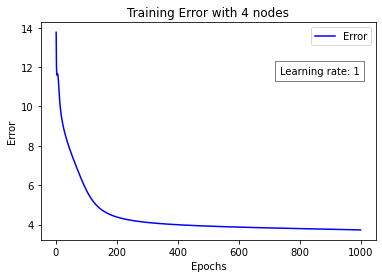

prediction_network:  [[{&#39;weights&#39;: [0.4965419730384948, 42.8208475794125, -3.9015893583315737]}, {&#39;weights&#39;: [28.630580023065367, 1.30273258805524, 3.164634500210669]}, {&#39;weights&#39;: [1.5044073773875937, 37.20474863036335, 3.48634481582044]}, {&#39;weights&#39;: [45.8158928067723, -0.9566300616688537, -2.659254483177219]}], [{&#39;weights&#39;: [15.647490503374597, -13.172111294021326, -10.964537813898813, 15.710553164790982, 6.140202622669266]}, {&#39;weights&#39;: [-15.64783545913924, 13.17243873148604, 10.964827186544468, -15.71089603964238, -6.140436275991548]}]]


In [5]:
# This cell is for running training on the dataset in which I have added some extra points (all in the square of size 1 centered at origin).
# The cell for training on the dataset provided in homework is 1 cell below.

Initial_network = [[{'weights': [-0.7621764006364317, 13.413159802195512, -4.205275583522489]}, {'weights': [21.399783490503765, -0.1459231768571693, 3.9502944765046233]}, {'weights': [0.26071688141565813, 28.353012964178795, 2.5259659073280694]}, {'weights': [22.76489662560973, 0.20763140581019643, -1.7934700058672997]}], [{'weights': [8.217085471783731, -8.90876832545036, -9.992744739662633, 9.971211949020903, 5.040115989257821]}, {'weights': [-8.218256402038454, 8.909878380203223, 9.99421872733163, -9.9727231560631, -5.040812974236946]}]]

input_dataset = training_dataset_expanded
number_of_inputs = len(input_dataset[0]) - 1
number_of_outputs = len(set([x[-1] for x in input_dataset]))
node_number_in_hidden_layer = 4

#Training function has following parameters: 1. Initial network, 2. Dataset, 3. Number of epochs, 4. Learning Rate, 5. Number of outputs, 6. Boolean for error plot, 7. Number of nodes in the hidden layer respectively.
network = training(Initial_network, input_dataset, 1000, 1, number_of_outputs, True, node_number_in_hidden_layer)

# The code below is to extract a trained network from the output we get from the training function as it contains some other values added by me during training like update_term etc.
prediction_network = []
for layer in network:
    nodes = []
    for node in layer:
        nodes.append({'weights':node["weights"]})
    prediction_network.append(nodes)
print("prediction_network: ",prediction_network)

True output=0, Predicted value=0
True output=0, Predicted value=0
True output=0, Predicted value=0
True output=0, Predicted value=0
True output=0, Predicted value=0
True output=0, Predicted value=0
Wrong Output for  [0.1935192334278344, -0.03385171749689664, 0]
True output=0, Predicted value=1
True output=0, Predicted value=0
True output=0, Predicted value=0
True output=0, Predicted value=0
True output=0, Predicted value=0
True output=0, Predicted value=0
True output=0, Predicted value=0
True output=0, Predicted value=0
Wrong Output for  [0.011791415331936728, -0.5415767562264067, 0]
True output=0, Predicted value=1
True output=0, Predicted value=0
True output=0, Predicted value=0
True output=0, Predicted value=0
True output=0, Predicted value=0
True output=0, Predicted value=0
True output=0, Predicted value=0
True output=0, Predicted value=0
Wrong Output for  [-0.014085294731122966, 0.1912367358631768, 0]
True output=0, Predicted value=1
True output=0, Predicted value=0
True output=0,

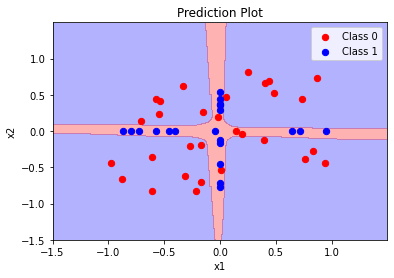

In [6]:
# Please note: The training cell has to be urn before this as the predicted_network variable comes from there.
# This cell is for tesing or predicting output from the network trained on bigger dataset.
dataset_for_testing = test_dataset
test_correct = 0

# I am sending one set of datapoints at a time to my prediction function and then comparing it with the actual value.
for row in dataset_for_testing:
    prediction = predict(prediction_network, row)
    if prediction==row[-1]:
        test_correct += 1   
    else:
        print("Wrong Output for ",row)
    print('True output=%d, Predicted value=%d' % (row[-1], prediction))
print("Validation_accuracy = ",(test_correct/len(dataset_for_testing)*100),"%")

# This function calling the plotting function which helps visualize the trained network.
plotting(dataset_for_testing,prediction_network, title = "Prediction Plot")

&gt;epoch=0, lrate=1.000, error=0.024
&gt;epoch=1, lrate=1.000, error=0.023
&gt;epoch=2, lrate=1.000, error=0.022
&gt;epoch=3, lrate=1.000, error=0.021
&gt;epoch=4, lrate=1.000, error=0.021
&gt;epoch=5, lrate=1.000, error=0.020
&gt;epoch=6, lrate=1.000, error=0.020
&gt;epoch=7, lrate=1.000, error=0.019
&gt;epoch=8, lrate=1.000, error=0.019
&gt;epoch=9, lrate=1.000, error=0.019
&gt;epoch=10, lrate=1.000, error=0.018
&gt;epoch=11, lrate=1.000, error=0.018
&gt;epoch=12, lrate=1.000, error=0.018
&gt;epoch=13, lrate=1.000, error=0.017
&gt;epoch=14, lrate=1.000, error=0.017
&gt;epoch=15, lrate=1.000, error=0.017
&gt;epoch=16, lrate=1.000, error=0.017
&gt;epoch=17, lrate=1.000, error=0.016
&gt;epoch=18, lrate=1.000, error=0.016
&gt;epoch=19, lrate=1.000, error=0.016
&gt;epoch=20, lrate=1.000, error=0.016
&gt;epoch=21, lrate=1.000, error=0.015
&gt;epoch=22, lrate=1.000, error=0.015
&gt;epoch=23, lrate=1.000, error=0.015
&gt;epoch=24, lrate=1.000, error=0.015
&gt;epoch=25, lrate=1.000, error=0.

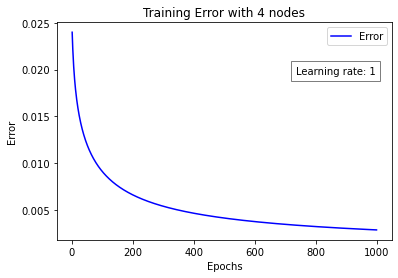

prediction_network:  [[{&#39;weights&#39;: [-0.6295349291633631, 13.87851592367311, -3.8276381252006764]}, {&#39;weights&#39;: [21.409259583393915, -0.21812970174432048, 4.271688340605391]}, {&#39;weights&#39;: [0.23134865487465256, 28.353025704308177, 3.656580864215186]}, {&#39;weights&#39;: [22.765533210868103, 0.4338500801332189, -3.2261724243377694]}], [{&#39;weights&#39;: [9.12477385818188, -9.544473759336967, -9.717737360095468, 9.917325792093003, 4.8771278495627906]}, {&#39;weights&#39;: [-9.125531065981818, 9.545465033269437, 9.719141584664014, -9.91862211627958, -4.877965514139657]}]]


In [7]:
# This cell is for running training on the dataset given in the problem statement.

Initial_network = [[{'weights': [-0.7621764006364317, 13.413159802195512, -4.205275583522489]}, {'weights': [21.399783490503765, -0.1459231768571693, 3.9502944765046233]}, {'weights': [0.26071688141565813, 28.353012964178795, 2.5259659073280694]}, {'weights': [22.76489662560973, 0.20763140581019643, -1.7934700058672997]}], [{'weights': [8.217085471783731, -8.90876832545036, -9.992744739662633, 9.971211949020903, 5.040115989257821]}, {'weights': [-8.218256402038454, 8.909878380203223, 9.99421872733163, -9.9727231560631, -5.040812974236946]}]]

input_dataset = data_provided_in_hw
number_of_inputs = len(input_dataset[0]) - 1
number_of_outputs = len(set([x[-1] for x in input_dataset]))
node_number_in_hidden_layer = 4

#Training function has following parameters: 1. Initial network, 2. Dataset, 3. Number of epochs, 4. Learning Rate, 5. Number of outputs, 6. Boolean for error plot, 7. Number of nodes in the hidden layer respectively.
network = training(Initial_network, input_dataset, 1000, 1, number_of_outputs, True, node_number_in_hidden_layer)

# The code below is to extract a trained network from the output we get from the training function as it contains some other values added by me during training like update_term etc.
prediction_network = []
for layer in network:
    nodes = []
    for node in layer:
        nodes.append({'weights':node["weights"]})
    prediction_network.append(nodes)
print("prediction_network: ",prediction_network)


True output=0, Predicted value=0
Wrong Output for  [-0.7093891508634509, 0.1431255749492626, 0]
True output=0, Predicted value=1
True output=0, Predicted value=0
True output=0, Predicted value=0
True output=0, Predicted value=0
True output=0, Predicted value=0
Wrong Output for  [0.1935192334278344, -0.03385171749689664, 0]
True output=0, Predicted value=1
True output=0, Predicted value=0
True output=0, Predicted value=0
Wrong Output for  [0.3971522382401944, -0.12227491457832929, 0]
True output=0, Predicted value=1
True output=0, Predicted value=0
True output=0, Predicted value=0
True output=0, Predicted value=0
Wrong Output for  [-0.15389405974995074, 0.2652129613671035, 0]
True output=0, Predicted value=1
Wrong Output for  [0.011791415331936728, -0.5415767562264067, 0]
True output=0, Predicted value=1
Wrong Output for  [0.05572982655382708, 0.47401592807198023, 0]
True output=0, Predicted value=1
True output=0, Predicted value=0
True output=0, Predicted value=0
True output=0, Predict

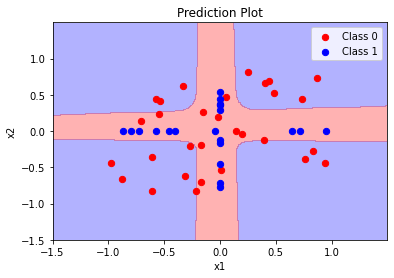

In [8]:
# Please note: The training cell has to be urn before this as the predicted_network variable comes from there.
# This cell is for tesing or predicting output from the network trained on bigger dataset.
dataset_for_testing = test_dataset
test_correct = 0

# I am sending one set of datapoints at a time to my prediction function and then comparing it with the actual value.
for row in dataset_for_testing:
    prediction = predict(prediction_network, row)
    if prediction==row[-1]:
        test_correct += 1   
    else:
        print("Wrong Output for ",row)
    print('True output=%d, Predicted value=%d' % (row[-1], prediction))
print("Validation_accuracy = ",(test_correct/len(dataset_for_testing)*100),"%")

# This function calling the plotting function which helps visualize the trained network.
plotting(dataset_for_testing,prediction_network, title = "Prediction Plot")